<a href="https://colab.research.google.com/github/jujuGthb/Apple_Stock_Price_Prediction_II/blob/main/appl_pred_reformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import os
project_dir = os.path.join('/content/drive/My Drive/Colab Notebooks')
model_path = os.path.join(project_dir, 'aapl_stock_prediction_reformer.keras')


In [ ]:
!pip install --upgrade yfinance
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [2]:
import yfinance as yf
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Data Collection

In [3]:
def download_data_with_retry(ticker, start, end, interval, max_retries=5, delay=5):
    for attempt in range(max_retries):
        try:
            data = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=False)


            print("Download successful!")
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(delay)
    print("All retry attempts failed.")
    return None

# parameters
ticker = 'AAPL'
start_date = '2004-01-01'
end_date = '2024-01-01'
interval = '1d'

# Downloading data
data = download_data_with_retry(ticker, start_date, end_date, interval)


if data is not None:
    print(f"Number of records downloaded: {len(data)}")
else:
    print("Data download failed.")

[*********************100%***********************]  1 of 1 completed

Download successful!
Number of records downloaded: 5033


In [4]:
data.head(5)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2004-01-02,0.320548,0.380000,0.388393,0.378214,0.384821,144642400
2004-01-05,0.333954,0.395893,0.399821,0.382500,0.382500,395018400
2004-01-06,0.332749,0.394464,0.400357,0.387679,0.397321,509348000
2004-01-07,0.340281,0.403393,0.407679,0.391607,0.394643,586874400
2004-01-08,0.351880,0.417143,0.423750,0.404464,0.407857,460303200


##### Checking  MultiIndex columns

In [5]:

if isinstance(data.columns, pd.MultiIndex):

    data.columns = data.columns.droplevel(0)

data.columns = ['adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [7]:
data = data.round(2)
data.head(5)

,adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2004-01-02,0.32,0.38,0.39,0.38,0.38,144642400
2004-01-05,0.33,0.40,0.40,0.38,0.38,395018400
2004-01-06,0.33,0.39,0.40,0.39,0.40,509348000
2004-01-07,0.34,0.40,0.41,0.39,0.39,586874400
2004-01-08,0.35,0.42,0.42,0.40,0.41,460303200


## Adding Columns

#### Feature Engineering

In [8]:

# Time-Based Features
data['DayofWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter

# Lagged Features (previous day's values)
data['Close_Lag1'] = data['Close'].shift(1)
data['Volume_Lag1'] = data['Volume'].shift(1)


data['Price Change %'] = data['Close'].pct_change() * 100
data['Volatility_20'] = data['Close'].rolling(window=20).std()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

# Interaction Features
data['Close_Volatility'] = data['Close'] * data['Volatility_20']



if isinstance(data.columns, pd.MultiIndex):

    data.columns = data.columns.droplevel(0)

    data.columns = ['adj Close', 'Close', 'High', 'Low', 'Open', 'Volume','Price Change %', 'Volatility_20', 'SMA_50', 'EMA_50']



data = data.round(2)




In [9]:
data.to_csv('AAPL_stock_data.csv')

## Data Processing

In [ ]:
import pandas as pd

data = pd.read_csv('AAPL_stock_data.csv', header=0, parse_dates=['Date'], index_col='Date')

data = data.bfill()



print(f"Data Info:\n {data.info}")
print(f"Sum of null data:\n {data.isnull().sum()}")






In [ ]:
data.tail(5)

## Visualizing Data

## Model Building

#### Normalize the features

In [12]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Select the input features and target variable (e.g., 'Close' price)
features = data.columns[data.columns != 'Close']  # Exclude the target column 'Close'
X = data[features].values  # Feature set (all columns except 'Close')
y = data['Close'].values  # Target variable ('Close' price)

# Train-test split (no shuffling as this is time-series data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize the features (train set first, then test set)
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the training data
X_train = scaler.fit_transform(X_train)

# Normalize the test data using the same scaler
X_test = scaler.transform(X_test)



In [13]:
# Normalize the target variable (y_train and y_test)
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the training target variable
y_train = target_scaler.fit_transform(y_train.reshape(-1, 1))

# Transform the test target variable using the same scaler
y_test = target_scaler.transform(y_test.reshape(-1, 1))


#### Model Definition

In [32]:

import torch
import torch.nn as nn

class ReformerStockModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ReformerStockModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.fc3 = nn.Linear(hidden_size, hidden_size)



    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation after the first layer
        x = self.fc2(x)
        return x

# Define model, optimizer, and loss function
input_size = X_train.shape[1]
hidden_size = 128
num_classes = 1
model = ReformerStockModel(input_size, hidden_size, num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


#### Model Training

Epoch [1/100], Loss: 0.0599
Epoch [2/100], Loss: 0.0500
Epoch [3/100], Loss: 0.0416
Epoch [4/100], Loss: 0.0346
Epoch [5/100], Loss: 0.0290
Epoch [6/100], Loss: 0.0245
Epoch [7/100], Loss: 0.0211
Epoch [8/100], Loss: 0.0184
Epoch [9/100], Loss: 0.0164
Epoch [10/100], Loss: 0.0148
Epoch [11/100], Loss: 0.0133
Epoch [12/100], Loss: 0.0120
Epoch [13/100], Loss: 0.0106
Epoch [14/100], Loss: 0.0092
Epoch [15/100], Loss: 0.0077
Epoch [16/100], Loss: 0.0063
Epoch [17/100], Loss: 0.0049
Epoch [18/100], Loss: 0.0037
Epoch [19/100], Loss: 0.0028
Epoch [20/100], Loss: 0.0020
Epoch [21/100], Loss: 0.0015
Epoch [22/100], Loss: 0.0013
Epoch [23/100], Loss: 0.0013
Epoch [24/100], Loss: 0.0014
Epoch [25/100], Loss: 0.0016
Epoch [26/100], Loss: 0.0017
Epoch [27/100], Loss: 0.0019
Epoch [28/100], Loss: 0.0020
Epoch [29/100], Loss: 0.0020
Epoch [30/100], Loss: 0.0019
Epoch [31/100], Loss: 0.0019
Epoch [32/100], Loss: 0.0018
Epoch [33/100], Loss: 0.0017
Epoch [34/100], Loss: 0.0017
Epoch [35/100], Loss: 0

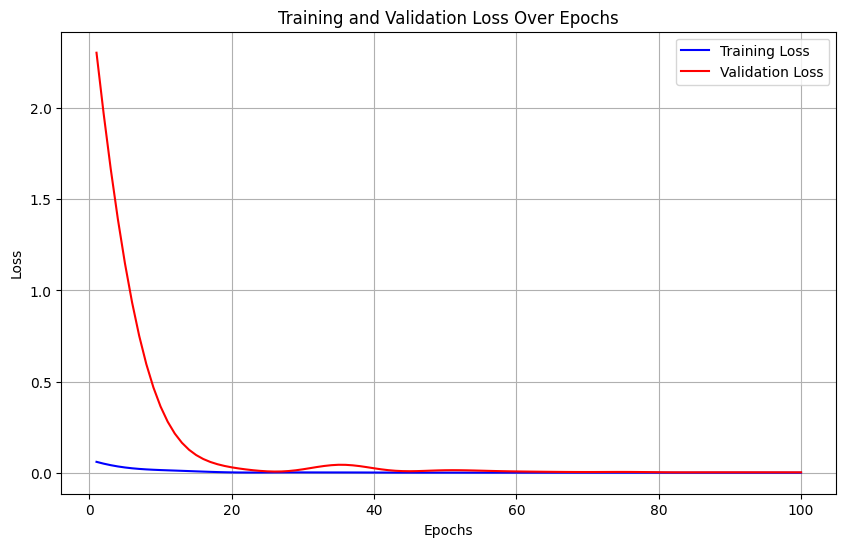

Test Loss: 0.0023, Test MAE: 0.0389


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define a simple model for regression
class ReformerStockModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ReformerStockModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation after the first layer
        x = self.fc2(x)  # Output layer
        return x

# Define model, optimizer, and loss function
input_size = X_train.shape[1]
hidden_size = 128
num_classes = 1
model = ReformerStockModel(input_size, hidden_size, num_classes)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()

    # Forward pass for training
    outputs = model(X_train_tensor)  # Get predictions
    train_loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation loss calculation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    # Store losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print loss every epoch
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    test_mae = torch.mean(torch.abs(predictions - y_test_tensor))  # Calculate MAE for test data
    print(f"Test Loss: {test_loss.item():.4f}, Test MAE: {test_mae.item():.4f}")



### Evaluate the Model

In [39]:

import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


model.eval()
with torch.no_grad():
    # Get predictions for the test data
    y_pred_tensor = model(X_test_tensor)

# Convert predictions and actual values to NumPy arrays for sklearn metrics
y_pred = y_pred_tensor.detach().numpy()
y_test_actual = y_test_tensor.detach().numpy()


# Calculate the metrics
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

# Print all the metrics
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")



MSE: 0.0023255376145243645
MAE: 0.03889698535203934
MAPE: 2.09659393876791%
RMSE: 0.04822382828565526
R-squared: 0.9890087246894836


##### Save the model

In [43]:
torch.save(model.state_dict(), model_path)

##### Load the saved model

In [44]:
model = ReformerStockModel(input_size, hidden_size, num_classes)

model.load_state_dict(torch.load('reformer_stock_model.pth'))

model.eval()

<ipython-input-44-a67b79450a3c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('reformer_stock_model.pth'))


ReformerStockModel(
  (fc1): Linear(in_features=15, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

#### Plot Predicted and Actual Prices

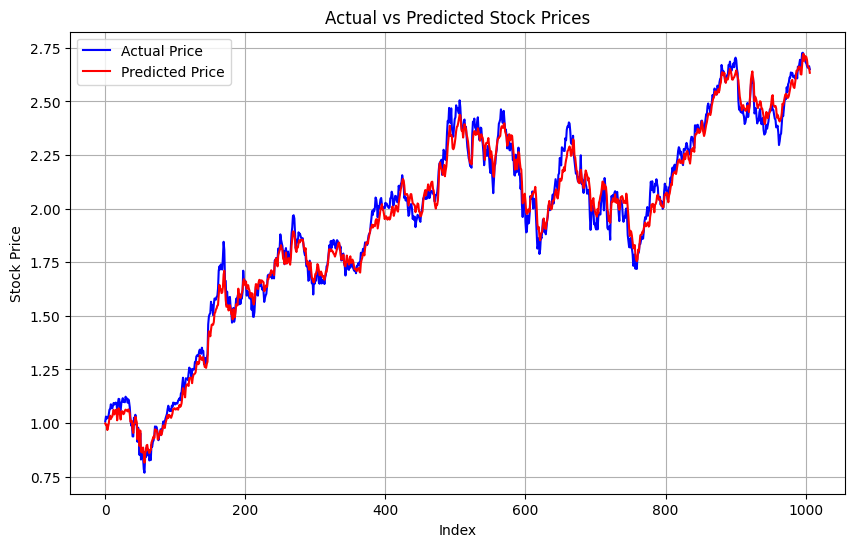

In [40]:
import matplotlib.pyplot as plt

# Make predictions on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Convert predictions and actual values to numpy for easy plotting
predicted_prices = predictions.numpy().flatten()
actual_prices = y_test_tensor.numpy().flatten()

# Plotting the actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label='Actual Price', color='blue')
plt.plot(range(len(predicted_prices)), predicted_prices, label='Predicted Price', color='red')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()
